In [1]:
import os, sys, re, functools, itertools, collections, time, random, pickle, warnings, json, subprocess
pkg_path = '/home/jupyter/code'
if pkg_path not in sys.path:
    sys.path.append(pkg_path)
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas

import torch
import torch.nn as nn

from utility import get_label_image, get_cor, get_cor_map, get_topk_indices, get_cor_map_4d, get_local_mean
from utility import get_prime_factors, get_local_median, scale_and_shift
from visualization import imshow, plot_image_label_overlay, make_video_ffmpeg, get_good_colors, plot_colortable, save_gif_file
from models import UNet
from denoise import get_denoised_mat, model_denoise, SeparateNet
from segmentation import get_traces, semi_supervised_segmentation

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
%load_ext autoreload
%autoreload 2

In [2]:
data_folder = '/home/jupyter/docker'
file_prefix = 'demo'
mat = np.load(f'{data_folder}/{file_prefix}.npy')
if file_prefix == 'demo':
    mat = mat.transpose((2, 0, 1))
mat = mat.astype('float32')
if file_prefix == 'mat':
    target_data_folder = '/home/jupyter/notebooks/workspace/optosynth_test_mb_2'
    target = np.load(f'{target_data_folder}/clean.npy') - np.load(f'{target_data_folder}/trend.npy')

In [5]:
mat_denoised = np.load(f'{data_folder}/{file_prefix}_denoised.npy')
mat_denoised = mat_denoised.transpose((2, 0, 1)).astype('float32')

In [16]:
make_video_ffmpeg(np.concatenate([scale_and_shift(m, scale=255) for m in [mat, mat_denoised, mat-mat_denoised]], axis=1), 
                  f'{data_folder}/{file_prefix}_denoised.avi')

In [3]:
mat_reduced = np.load(f'{data_folder}/{file_prefix}_reduced.npy')
mat_reduced = mat_reduced.transpose((2, 0, 1)).astype('float32')

if file_prefix == 'mat':
    make_video_ffmpeg(np.concatenate([scale_and_shift(m, scale=255) for m in [mat, target, mat_reduced, mat-mat_reduced]], axis=1), 
                      f'{data_folder}/{file_prefix}_reduced.avi')
elif file_prefix == 'demo':
    make_video_ffmpeg(np.concatenate([scale_and_shift(m, scale=255) for m in [mat, mat_reduced, mat-mat_reduced]], axis=1), 
                      f'{data_folder}/{file_prefix}_reduced.avi')

In [25]:
with open(f'{data_folder}/{file_prefix}_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [27]:
results['fin_rlt'].keys()

dict_keys(['a', 'c', 'c_tf', 'b', 'fb', 'ff', 'res', 'corr_img_all_r', 'num_list'])

In [29]:
masks = results['fin_rlt']['a']

In [37]:
traces = results['fin_rlt']['c']
traces_tf = results['fin_rlt']['c_tf']

In [31]:
nframe, nrow, ncol = mat.shape

In [39]:
fig_folder = f'{data_folder}/results'
if not os.path.exists(fig_folder):
    print(f'Create {fig_folder}')
    os.makedirs(fig_folder)

Create /home/jupyter/docker/results


In [41]:
for i in range(masks.shape[1]):
    fig, ax = plt.subplots(2, figsize=(16, 16))
    im = ax[0].imshow(masks[:,i].reshape(nrow, ncol))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    ax[1].plot(traces_tf[:,i])
    ax[1].set_title(f'Neuron {i}')
    fig.tight_layout()
    plt.savefig(f'{fig_folder}/{i}.png')
    plt.close()
save_gif_file(imgs=[f'{fig_folder}/{i}.png' for i in range(masks.shape[1])], save_path=f'{fig_folder}/{file_prefix}_detected_neurons.gif')

In [ ]:
def plain_nmf(mat, n=4, mask=None, fig_folder=None, save_npy=False, verbose=False):
    from sklearn.decomposition import NMF
    if mat.ndim == 3:
        nframe, nrow, ncol = mat.shape
        mat = mat.reshape(nframe, -1)
    else:
        assert mask is not None
        nrow, ncol = mask.shape
    M = mat.cpu().numpy()
    min_val = M.min()
    M = M - min_val
    if fig_folder is not None and not os.path.exists(fig_folder):
        print(f'Creat folder {fig_folder}')
        os.makedirs(fig_folder)
    
    start_time = time.time()
    model = NMF(n_components=n, init='random', random_state=0)
    W = model.fit_transform(M)
    H = model.components_
    end_time = time.time()
    if verbose:
        print(n, end_time - start_time)
    if fig_folder is not None and save_npy:
        np.save(f'{fig_folder}/w_{n}.npy', W)
        np.save(f'{fig_folder}/h_{n}.npy', H)

    for i in range(H.shape[0]):
        fig, ax = plt.subplots(2, figsize=(20, 15))
        ax[0].set_title(f'Component {i+1}')
        if mask is None:
            image = H[i].reshape(nrow, ncol)
        else:
            image = np.zeros((nrow, ncol))
            image[mask] = H[i]
        im = ax[0].imshow(image)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)
        ax[1].plot(W[:, i])
        ax[1].set_title(f'Component {i+1}')
        fig.tight_layout()
        if fig_folder is not None:
            plt.savefig(f'{fig_folder}/{i}.png')
            plt.close()
        else:
            plt.show()
    return W, H

In [ ]:
data_folders = ['D1_FOV1_W1_at134043', 'D1_FOV1_W2_at134159']
data_folder = data_folders[1]

loss_history = np.load(f'{data_folder}/noise2self/loss__denoise.npy')

In [ ]:
loss_history_mean = get_local_mean(torch.from_numpy(loss_history).float().to(device), 500).squeeze().cpu().numpy()
tmp = loss_history.reshape(-1, 500)
tmp = np.abs((tmp[1:] - tmp[:-1]).mean(1))
plt.scatter(range(len(tmp)), tmp, color=['r' if y < 1e-3 else 'g' for y in tmp])

In [ ]:
if not os.path.exists(f'{data_folder}/mat.npy'):
    command = ['gsutil', '-m', 'cp', f'gs://broad-opp-voltage/sami_2015/processed/{data_folder}/mat.npy', data_folder]
    response = subprocess.run(command, capture_output=True)
    assert response.returncode == 0
mat = torch.from_numpy(np.load(f'{data_folder}/mat.npy')).float().to(device)

filename = [s for s in os.listdir(f'{data_folder}/noise2self') if re.search('^denoised_movie_frame0to', s) and re.search('.npy$', s)][0]
filepath = f'{data_folder}/noise2self/{filename}'
denoised_mat = torch.from_numpy(np.load(filepath)).float().to(device)

save_path = f'{data_folder}/noise2self/{filename[:-4]}.avi'
make_video_ffmpeg(torch.cat([mat, denoised_mat], dim=1), save_path)

command = ['gsutil', '-m', 'cp', save_path, 
           f'gs://broad-opp-voltage/sami_2015/processed/{data_folder}/noise2self/']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0

In [ ]:
cor_map = get_cor_map_4d(mat.reshape(10, 650, 180, 512))
denoised_cor_map = get_cor_map_4d(denoised_mat.reshape(10, 650, 180, 512))

In [ ]:
imshow(cor_map)
imshow(denoised_cor_map)

In [ ]:
label_image, regions = get_label_image(denoised_cor_map, plot=True)
plot_image_label_overlay(cor_map, label_image)

# Load data

In [2]:
data_folder = 'optosynth_test_mb'
# data_folder = '../data'

mat = torch.from_numpy(np.load(f'{data_folder}/mat.npy')).float().to(device)

In [3]:
trend = torch.from_numpy(np.load(f'{data_folder}/trend.npy')).float().to(device)
clean = torch.from_numpy(np.load(f'{data_folder}/clean.npy')).float().to(device)

In [4]:
masks = torch.from_numpy(np.load(f'{data_folder}/masks_nyx.npy')).to(device)
soma_coords = torch.from_numpy(np.load(f'{data_folder}/soma_coords_n2.npy')).to(device)

In [5]:
traces = torch.from_numpy(np.load(f'{data_folder}/neuron_mean_fluorescence_nt.npy')).float().to(device)

nframe, nrow, ncol = mat.shape
mask_soma = torch.zeros(nrow, ncol).bool()
mask_soma[soma_coords[:, 1], soma_coords[:, 0]] = True
mask_cell = masks.float().max(0)[0].bool()
target = clean - trend

In [ ]:
save_folder = '2d-noise2self_with_features'
filepath = f'{save_folder}/denoised_movie_full_step64000.npy'
denoised_mat = torch.from_numpy(np.load(filepath)).float().to(device)

In [ ]:
fig_folder = f'{data_folder}/individual_neurons'
if not os.path.exists(fig_folder):
    print(f'Create {fig_folder}')
    os.makedirs(fig_folder)
if not os.path.exists(f'{fig_folder}/individual_neurons.gif'):
    for i in range(len(masks)):
        y, x = torch.nonzero(masks[i], as_tuple=True)
        fig, ax = plt.subplots(figsize=(16, 9))
        im = ax.imshow(cor_map.cpu().numpy(), cmap='gray')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.5)
        ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
        ax.set_title(f'Neuron {i} (soma is red)')
        fig.tight_layout()
        plt.savefig(f'{fig_folder}/{i}.png')
        plt.close()
    save_gif_file(imgs=[f'{fig_folder}/{i}.png' for i in range(len(masks))], save_path=f'{fig_folder}/individual_neurons.gif')

    img = masks.sum(0).cpu()
    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(img, cmap=matplotlib.cm.get_cmap('viridis', img.max()+1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    ax.scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r', s=20, alpha=0.5)
    ax.set_title('Overlapping of neurons (red dots are somas)')
    fig.tight_layout()
    plt.savefig(f'{fig_folder}/overlapping.png')
    plt.show()
    
if not os.path.exists(f'{fig_folder}/individual_neurons_with_spikes.gif'):
    for i in range(len(masks)):
        y, x = torch.nonzero(masks[i], as_tuple=True)
        fig, ax = plt.subplots(2, figsize=(16, 16))
        im = ax[0].imshow(cor_map.cpu().numpy(), cmap='gray')
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)
        ax[0].scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.5)
        ax[0].scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
        ax[0].set_title(f'Neuron {i} (soma is red)')
        ax[1].plot(traces[i].cpu())
        ax[1].set_title(f'Neuron {i} mean fluorescence trace')
        fig.tight_layout()
        plt.savefig(f'{fig_folder}/{i}.png')
        plt.close()
    save_gif_file(imgs=[f'{fig_folder}/{i}.png' for i in range(len(masks))], save_path=f'{fig_folder}/individual_neurons_with_spikes.gif')

# Spectral clustering

In [4]:
cor_map = get_cor_map(mat, topk=5)
label_image, regions = get_label_image(cor_map, plot=False)

In [ ]:
torch.save(model, 'model.pt')

In [ ]:
model = torch.load('model.pt')

1 loss=0.7609868049621582
20 loss=0.43313437700271606
40 loss=0.3075268566608429
60 loss=0.05235478654503822
80 loss=0.18382500112056732
100 loss=0.03356650471687317


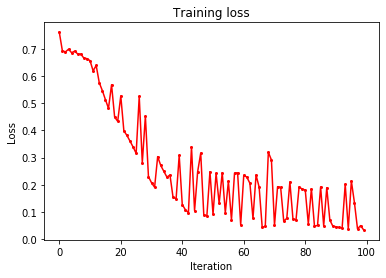

158.07007670402527


In [18]:
torch.cuda.empty_cache()
start_time = time.time()
soft_mask, model = semi_supervised_segmentation(mat, cor_map=cor_map, model=None, out_channels=[8,8,8,8], 
                                                kernel_size=3, frames_per_iter=100, num_iters=100, 
                                                print_every=20, select_frames=False, optimizer_fn=torch.optim.AdamW, 
                                                optimizer_fn_args = {'lr': 1e-2, 'weight_decay': 1e-3}, 
                                                save_loss_folder=None, loss_threshold=0, reduction='mean',
                                                last_out_channels=None,
                                                return_model=True, verbose=True)
print(time.time() - start_time)

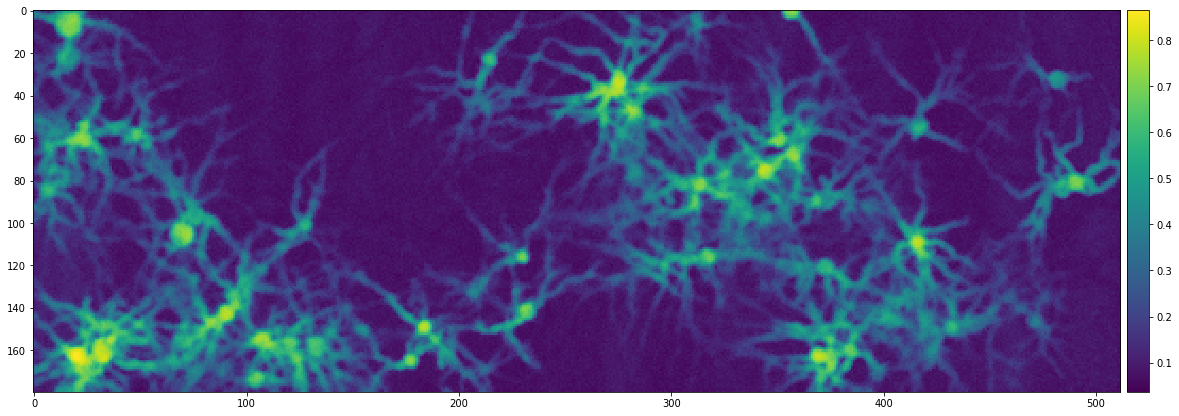

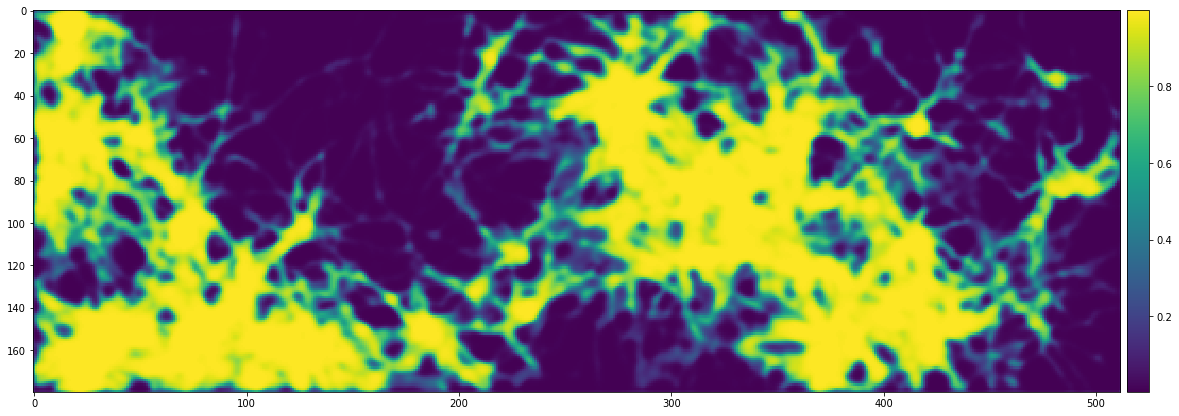

In [19]:
imshow(cor_map)
imshow(soft_mask)

In [15]:
torch.cuda.empty_cache()
frames_per_iter = 100
num_iters = 10
start_time = time.time()
with torch.no_grad():
    soft_masks = []
    starts = []
    for i in range(num_iters):
        start = np.random.choice(901)
        starts.append(start)
        x = mat[start:start+frames_per_iter]
        y_pred = model(x).mean(1)
        soft_mask = torch.softmax(y_pred, dim=0)[1]
        soft_masks.append(soft_mask)
end_time = time.time()
print(f'Time spent: {end_time - start_time}')
soft_mask = torch.stack(soft_masks, dim=0).mean(0)

Time spent: 1.6603524684906006


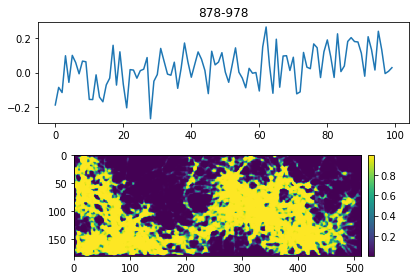

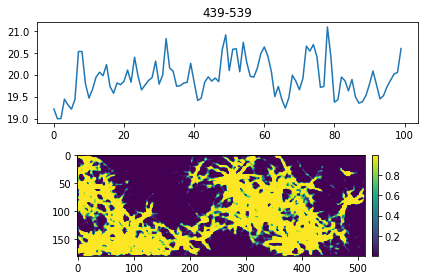

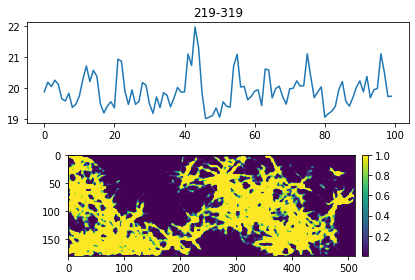

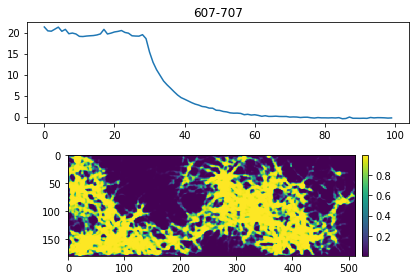

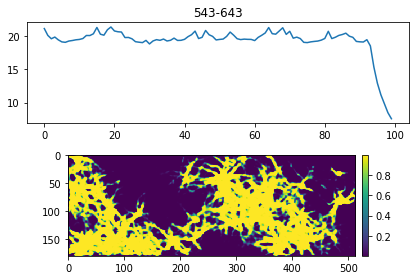

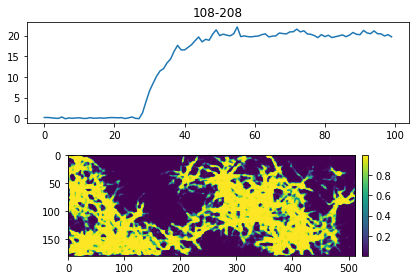

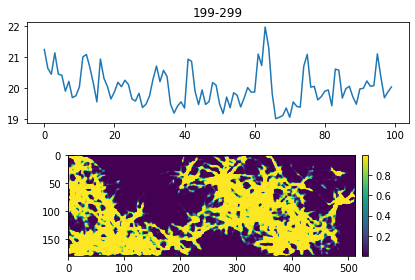

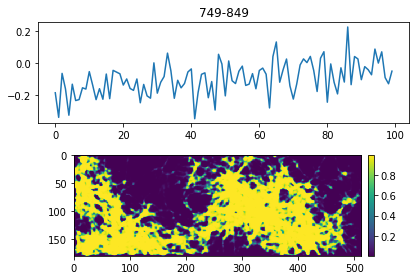

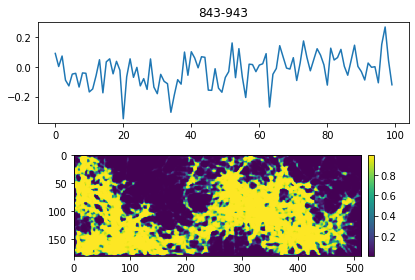

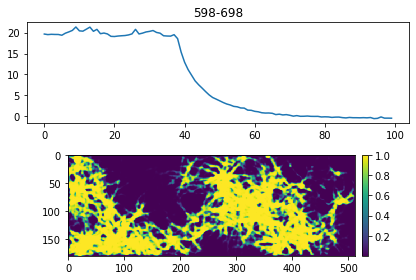

In [16]:
for i, s in enumerate(starts):
    fig, ax = plt.subplots(2)
    ax[0].plot(mat[s:s+frames_per_iter].mean((1,2)).cpu())
    ax[0].set_title(f'{s}-{s+frames_per_iter}')
    im = ax[1].imshow(soft_masks[i].cpu().numpy())
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    fig.tight_layout()
    plt.show()

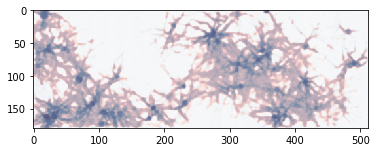

In [17]:
plt.imshow(soft_mask.cpu(), cmap='Reds', alpha=0.5)
plt.imshow(cor_map.cpu(), cmap='Blues', alpha=0.5)

In [ ]:
soft_mask = torch.stack(soft_masks, dim=0).mean(0)
imshow(soft_mask)

In [ ]:
for i in range(len(masks)):
    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(soft_mask.cpu().numpy(), cmap='gray', alpha=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    y, x = torch.nonzero(masks[i], as_tuple=True)
    ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.2)
    ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
    ax.set_title(f'Neuron {i} (soma is red)')
    fig.tight_layout()
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
im = ax.imshow(soft_mask.cpu().numpy(), cmap='gray', alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
for i in range(len(masks)):
    y, x = torch.nonzero(masks[i], as_tuple=True)
    ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.2)
for i in range(len(masks)):
    ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
ax.set_title(f'Neuron masks (soma is red)')
fig.tight_layout()
plt.show()

In [ ]:
from skimage.color import label2rgb
import matplotlib.patches as mpatches
bounding_box = True
img = label2rgb(label_image, image=cor_map.cpu())
fig, ax = plt.subplots(figsize=(16, 9))
im = ax.imshow(img)
if bounding_box:
    for i, region in enumerate(regions):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(minc, minr, i+1, color='r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax.scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r', s=20, alpha=0.5)
for i, (x, y) in enumerate(soma_coords):
    ax.text(x, y, i, color='b')
ax.set_title('Basic pipeline segmentation')
ax.set_axis_off()
fig.tight_layout()
# if not os.path.exists(f'{fig_folder}/segmentation_basic.png'):
#     plt.savefig(f'{fig_folder}/segmentation_basic.png')
plt.show()

In [ ]:
label_idx = 1
num_components = 4
minr, minc, maxr, maxc = regions[label_idx-1].bbox
selected_frame_slice = slice(100, 700)
selected_row_slice = slice(minr, maxr)
selected_col_slice = slice(minc, maxc)
selected_indices = (selected_frame_slice, selected_row_slice, selected_col_slice)

submat = denoised_mat[selected_indices]
mask = None
# sub_cor_map = get_cor_map(submat)
# sub_label_image, sub_regions = get_label_image(sub_cor_map, plot=True)


# submat = denoised_mat[selected_frame_slice, label_image==label_idx]
# mask = (label_image == label_idx)[selected_row_slice, selected_col_slice]

W, H = plain_nmf(submat, n=num_components, mask=mask, fig_folder=None, save_npy=False)

In [ ]:
neuron_idx = 31
# plt.plot(target[selected_frame_slice, soma_coords[neuron_idx, 1], soma_coords[neuron_idx, 0]].cpu())
plt.plot(traces[neuron_idx, selected_frame_slice].cpu())
plt.show()

# Plain NMF

In [ ]:
save_folder = '2d-noise2self_with_features'
filepath = f'{save_folder}/denoised_movie_full_step64000.npy'
pred = torch.from_numpy(np.load(filepath)).float().to(device)
select_idx = range(100, 700)

In [ ]:
spike_name = 'median-5'
pred_filtered = get_local_median(pred, window_size=15, dim=0)

In [ ]:
filepath = f'{save_folder}/mb-spike/spike.npy'
spike_name = 'mb-spike'
pred_filtered = torch.from_numpy(np.load(filepath)).float().to(device)

In [ ]:
make_video_ffmpeg(torch.cat([scale_and_shift(m, scale=255) 
                             for m in [target[select_idx], pred[select_idx], pred_filtered[[select_idx]]]], dim=1), 
                  f'{spike_name}.avi', 
                  normalize=False)

In [ ]:
M = pred_filtered[select_idx].reshape(600, -1).cpu().numpy()
min_val = M.min()
M = M - min_val

In [ ]:
from sklearn.decomposition import NMF
ns = [51]
fig_folder = f'{save_folder}/nmf_spike/{spike_name}'
if not os.path.exists(fig_folder):
    print(f'Creat folder {fig_folder}')
    os.makedirs(fig_folder)
for n in ns:
    start_time = time.time()
    model = NMF(n_components=n, init='random', random_state=0)
    W = model.fit_transform(M)
    H = model.components_
    end_time = time.time()
    print(n, end_time - start_time)
    np.save(f'{fig_folder}/w_{n}.npy', W)
    np.save(f'{fig_folder}/h_{n}.npy', H)

In [ ]:
for i in range(H.shape[0]):
    fig, ax = plt.subplots(2, figsize=(20, 15))
    ax[0].set_title(f'Component {i+1}')
    im = ax[0].imshow(H[i].reshape(180, 512))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    ax[1].plot(W[:, i])
    fig.tight_layout()
    plt.savefig(f'{fig_folder}/{i}.png')
    plt.close()
#     plt.show()

In [ ]:
from PIL import Image, ImageSequence
# Create the frames
frames = []
imgs = [f'{fig_folder}/{n}.png' for n in range(H.shape[0])]
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
frames[0].save(f'{fig_folder}/nmf.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1500, loop=0)

In [ ]:
cor_map = get_cor_map(mat, topk=4)
target = clean - trend

fig, ax = plt.subplots(3, figsize=(16, 21))
im = ax[0].imshow(cor_map.cpu().numpy())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[0].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[0].set_title('correlation map of noisy video (red dots are somas)')
im = ax[1].imshow(target.mean(0).cpu().numpy())
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[1].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[1].set_title('temporal mean of the clean video (red dots are somas)')
im = ax[2].imshow(clean.mean(0).cpu().numpy())
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[2].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[2].set_title('temporal mean of the clean video (before detrending)')
fig.tight_layout()
plt.savefig(f'{data_folder}/cor_map.png')
plt.show()

fig, ax = plt.subplots(10, 5, figsize=(20, 30))
for i in range(50):
    x, y = i//5, i%5
    ax[x, y].imshow((cor_map*masks[i].float()).cpu().numpy())
    ax[x, y].set_title(f'{i}')
    ax[x, y].scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r')
fig.tight_layout()
plt.title('Individual neurons on correlation map')
plt.savefig(f'{data_folder}/individual_neurons_cor_map.png')
plt.show()

plt.figure(figsize=(10, 30))
plt.plot(traces.T.cpu())
plt.title('Neuron mean fluorescence')
plt.savefig(f'{data_folder}/individual_neurons_mean_fluorescence.png')
plt.show()

In [ ]:
raw_traces = torch.stack([mat[:, mask].mean(dim=1) for mask in masks], dim=1).T.cpu().numpy()
clean_traces = torch.stack([target[:, mask].mean(dim=1) for mask in masks], dim=1).T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'g-.', markersize=1, alpha=0.8, label='noisy' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='clean' if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(raw_traces), step)
ax.legend()
ax.set_title('Mean traces (noisy and clean)')
plt.savefig(f'{data_folder}/mean_traces.png')
plt.show()

raw_traces = mat[:, mask_soma].T.cpu().numpy()
clean_traces = target[:, mask_soma].T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'g-.', markersize=1, alpha=0.8, label='noisy' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='clean' if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(raw_traces), step)
ax.legend()
ax.set_title('Soma traces (noisy and clean)')
plt.savefig(f'{data_folder}/soma_traces.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', f'{data_folder}/*png', f'gs://tma-opp-test/optosynth/optosynth_test_mb/data/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
save_folder = 'cellmincer-with_global_features_mse'
if not os.path.exists(save_folder):
    print(f'Download folder gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}')
    command = ['gsutil', '-m', 'cp', '-r', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}', '.']
    response = subprocess.run(command, capture_output=True)
    assert response.returncode == 0

# Noise2Self

In [ ]:
print(save_folder)
movie_start_idx = 100
movie_end_idx = 700
if re.search('cellmincer', save_folder):
    num_epochs = 80
    if re.search('epochs', save_folder):
        num_epochs = int(save_folder[-8:-6])
    num_iters = 1000
else:
    with open(f'{save_folder}/config.json', 'r') as f:
        config = json.load(f)
    num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
    num_epochs = sum([config[f'episode{e}']['train_settings']['num_epochs'] for e in range(num_episodes)])
    num_iters = config['episode0']['train_settings']['num_iters']
print(num_iters, num_epochs)

In [ ]:
target = (clean-trend)[movie_start_idx:movie_end_idx]
if not os.path.exists(f'{data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi'):
    print(f'Make video {data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi')
    make_video_ffmpeg(target, save_path=f'{data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi')
losses = []
losses_train = []
for epoch in range(num_epochs):
    pred = target.new_tensor(
        np.load(f'{save_folder}/denoised_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters * (epoch+1)}.npy', allow_pickle=True))
    losses.append([get_loss(pred, target, mask=None),
                   get_loss(pred, target, mask=mask_cell),
                   get_loss(pred, target, mask=mask_soma),
                   get_loss(pred, target, mask=~mask_cell)])
    losses_train.append([get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=None),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=mask_cell),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=mask_soma),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=~mask_cell)])
    print(epoch, losses[-1])
    print(epoch, losses_train[-1])
save_path = f'{save_folder}/diff_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters * (epoch+1)}.avi'
make_video_ffmpeg(pred - target, 
                  save_path=save_path)
command = ['gsutil', 'cp', save_path, f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0
losses = np.array(losses)
pandas.DataFrame(losses, columns=['all', 'cell', 'soma', 'background']).to_pickle(f'{save_folder}/rmse_losses.pkl')
losses_train = np.array(losses_train)
pandas.DataFrame(losses_train, columns=['all', 'cell', 'soma', 'background']).to_pickle(f'{save_folder}/rmse_losses_train.pkl')
fig, ax = plt.subplots(5, sharex=True, figsize=(10, 20))
ax[0].plot(losses[:, 0], 'ro-', label='all')
ax[0].legend()
ax[1].plot(losses[:, 1], 'bo-', label='cell')
ax[1].legend()
ax[2].plot(losses[:, 2], 'go-', label='soma')
ax[2].legend()
ax[3].plot(losses[:, 3], 'ko-', label='background')
ax[3].legend()
ax[4].plot(losses[:, 0], 'ro-', label='all')
ax[4].plot(losses[:, 1], 'bo-', label='cell')
ax[4].plot(losses[:, 2], 'go-', label='soma')
ax[4].plot(losses[:, 3], 'ko-', label='background')
ax[4].legend()
fig.tight_layout()
plt.savefig(f'{save_folder}/rmse_losses.png')
plt.show()

fig, ax = plt.subplots(5, sharex=True, figsize=(10, 20))
ax[0].plot(losses_train[:, 0], 'ro-', label='all')
ax[0].legend()
ax[1].plot(losses_train[:, 1], 'bo-', label='cell')
ax[1].legend()
ax[2].plot(losses_train[:, 2], 'go-', label='soma')
ax[2].legend()
ax[3].plot(losses_train[:, 3], 'ko-', label='background')
ax[3].legend()
ax[4].plot(losses_train[:, 0], 'ro-', label='all')
ax[4].plot(losses_train[:, 1], 'bo-', label='cell')
ax[4].plot(losses_train[:, 2], 'go-', label='soma')
ax[4].plot(losses_train[:, 3], 'ko-', label='background')
ax[4].legend()
fig.tight_layout()
plt.savefig(f'{save_folder}/rmse_losses_train.png')
plt.show()

command = ['gsutil', 'cp', f'{save_folder}/rmse*', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
# i = 3200
# model.load_state_dict(torch.load(f'{save_folder}/model_step{i}.pt'))

# mean_mat = mat.mean()
# std_mat = mat.std()
# denoised_mat = model_denoise(((mat - mean_mat) / std_mat)[movie_start_idx-frame_depth:movie_end_idx+frame_depth], model, ndim=ndim, frame_depth=frame_depth,
#                                  normalize=False, batch_size=batch_size_eval, replicate_pad=False)
# denoised_mat = denoised_mat * std_mat + mean_mat

# np.save(f'{save_folder}/denoised_movie_frame100to700_step{i}.npy', denoised_mat.cpu().numpy())

In [ ]:
save_folder = '2d-noise2self_with_features'
num_iters = 1600
num_epochs = 40
# save_folder = 'cellmincer-with_global_features'
# num_iters = 1000
# num_epochs = 80

filepath = f'{save_folder}/denoised_movie_frame100to700_step{num_iters*num_epochs}.npy'
if not os.path.exists(filepath):
    command = ['gsutil', '-m', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{filepath}', filepath]
    response = subprocess.run(command, capture_output=True)
    assert response.returncode == 0
pred = target.new_tensor(np.load(filepath))
# cor_map = get_cor_map(pred)
# imshow(cor_map, title='correlation map of predicted video', save_file=f'{save_folder}/cor_map_pred_{num_epochs}epochs.png')

In [ ]:
target = clean - trend
if re.search('cellmincer', save_folder):
    pred = target.new_tensor(np.load(f'{save_folder}/denoised_movie_frame0to1000_step{num_iters*num_epochs}.npy'))
else:
    pred = target.new_tensor(np.load(f'{save_folder}/denoised_movie_full_step{num_iters*num_epochs}.npy'))
cor_map = get_cor_map(pred-target, topk=4)
fig, ax = plt.subplots(3, figsize=(20, 20))
im = ax[0].imshow((pred-target).mean(0).cpu())
ax[0].set_title('temporal mean of (pred - target)')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
im = ax[1].imshow((pred-target).abs().mean(0).cpu())
ax[1].set_title('temporal mean of |pred - target|')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
im = ax[2].imshow(cor_map.cpu())
ax[2].set_title('correlation map of (pred - target)')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
fig.tight_layout()
plt.savefig(f'{save_folder}/temporal_mean_difference_{num_epochs}epochs.png')
plt.show()

fig, ax = plt.subplots(3, figsize=(16, 16))
ax[0].set_title('spatial mean')
ax[0].plot(pred.mean((1, 2)).cpu(), label='pred')
ax[0].plot(target.mean((1,2)).cpu(), label='target')
ax[0].legend()
ax[1].plot((pred-target).abs().mean((1,2)).cpu(), label='|pred - target|')
ax[1].legend()
ax[2].plot((pred-target).mean((1,2)).cpu(), label='pred - target')
ax[2].legend()
plt.savefig(f'{save_folder}/spatial_mean_difference_{num_epochs}epochs.png')
plt.show()

raw_traces = mat[:, mask_soma].T.cpu().numpy()
pred_traces = pred[:, mask_soma].T.cpu().numpy()
clean_traces = target[:, mask_soma].T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'b-', markersize=1, alpha=0.3, label='Input' if i==0 else None)
    ax.plot(pred_traces[i] - i*step, 'g-', markersize=1, alpha=0.8, label='Prediction' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='Target'if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(clean_traces), step)
ax.legend()
ax.set_title('Predicted soma traces')
plt.savefig(f'{save_folder}/denoised_soma_traces_{num_epochs}epochs.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', f'{save_folder}/*.png', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
command = ['gsutil', 'ls', 'gs://tma-opp-test/optosynth/optosynth_test_mb/results/']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0
folders = [f.split('/')[-2] for f in response.stdout.decode().split() if re.search('/$', f) and not re.search('figures|diff_movies', f)]
movie_start_idx = 100
movie_end_idx = 700

In [ ]:
folders = ['2d-noise2self_with_features', '2d-noise2self_with_features_80epochs', '2d-noise2self_with_features_80epochs_2',
           'cellmincer-with_global_features', 'cellmincer-with_global_features_mse']

In [ ]:
for folder in folders:
    if not os.path.exists(folder):
        print(folder)
        os.makedirs(folder)
        command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/rmse_losses.pkl', folder]
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
        if not re.search('^cellmincer', folder):
            command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/config.json', folder]
            response = subprocess.run(command, capture_output=True)
            assert response.returncode == 0
    if re.search('cellmincer', folder):
#         num_epochs = 80
#         if re.search('epochs', folder):
#             num_epochs = int(folder[-8:-6])
        num_iters = 1000
        command = ['gsutil', 'ls', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/denoised_movie_frame100to700*npy']
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
        num_epochs = max([int(s.split('step')[-1][:-4]) for s in response.stdout.decode().split()]) // num_iters
    else:
        if not os.path.exists(f'{folder}/config.json'):
            command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/config.json', folder]
            response = subprocess.run(command, capture_output=True)
            assert response.returncode == 0
        with open(f'{folder}/config.json', 'r') as f:
            config = json.load(f)
        num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
        num_epochs = sum([config[f'episode{e}']['train_settings']['num_epochs'] for e in range(num_episodes)])
        num_iters = config['episode0']['train_settings']['num_iters']
    print(folder, num_iters, num_epochs)

    target = (clean-trend)[movie_start_idx:movie_end_idx]
    filepath = f'{folder}/denoised_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters*num_epochs}.npy'
    if not os.path.exists(filepath):
        print(f'Download {filepath}')
        command = ['gsutil', '-m', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{filepath}', folder]
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
    pred = target.new_tensor(np.load(filepath))
    def normalize(mat, scale=255):
        return (mat - mat.min()) / (mat.max() - mat.min()) * scale
#     if not os.path.exists(f'diff_movies/{folder}.avi'):
#         print(f'Make video diff_movies/{folder}.avi')
#         make_video_ffmpeg(torch.cat([normalize(pred), normalize(target), normalize(pred-target)], dim=1), 
#                           save_path=f'diff_movies/{folder}.avi')

In [ ]:
colors = get_good_colors()

def get_label(model_name):
    if model_name.startswith('2d-noise2self') and not model_name.endswith('with_features'):
        return '2d-noise2self'
    elif model_name.startswith('3d-noise2self'):
        return '3d-noise2self'
    else:
        return model_name

In [ ]:
fig_folder = 'new-figures'

In [ ]:
# model_names = ['2d-noise2self', '3d-noise2self', 'separate-net', 'cellmincer-with_global_features', 'cellmincer-wo_global_features']
# model_names = ['2d-noise2self_2', '3d-noise2self_crop', 'separate-net']
# model_names += [folder for folder in folders 
#                if (re.search('cellmincer', folder)
#                    or folder in ['2d-noise2self_with_features'])]
# model_names += ['cellmincer-with_global_features', 'cellmincer-wo_global_features']
# model_names = [folder for folder in folders 
#                if (re.search('cellmincer', folder) and not re.search('wo', folder)
#                    or folder in ['2d-noise2self_with_features'])]
# model_names = ['2d-noise2self_with_features', 
#                'cellmincer-with_global_features', 
#                'cellmincer-with_global_features_mse',
#               ]

model_names = ['2d-noise2self_with_features', '2d-noise2self_with_features_80epochs_2', 
               'cellmincer-with_global_features', 'cellmincer-with_global_features_80epochs', 
               'cellmincer-with_global_features_mse',
               'cellmincer-with_global_features_mse_80epochs'
              ]
# model_names = folders
roi_names = ['RMSE of all pixels', 'RMSE of masked neuronal pixels', 'RMSE of 50 soma pixels', 'RMSE of background pixels']
# colors = ['r', 'g', 'b', 'k', 'c']
losses = [pandas.read_pickle(f'{model_name}/rmse_losses.pkl').values for model_name in model_names]
fig_folder = 'figures'
fig, ax = plt.subplots(len(roi_names), figsize=(20, 20))
for j, roi_name in enumerate(roi_names):
    for i, model_name in enumerate(model_names):
        y = losses[i][range(40) if re.search('2d-noise2self', model_name) else range(80), j]
        x = range(1, len(y)+1)
        ax[j].plot(x, y, 'o--' if re.search('wo', model_name) else 'o-', color=colors[i], label=model_name.split('_80epochs')[0])
        ax[j].set_title(roi_name)
        ax[j].set_xlabel('Epoch')
        ax[j].set_ylabel('RMSE')
        ax[j].legend()
fig.tight_layout()
# plt.savefig(f'{fig_folder}/five_models.png')
# plt.savefig(f'{fig_folder}/cellmincer-w-wo-features.png')
# plt.savefig(f'{fig_folder}/cellmincer-mse-losses.png')
# plt.savefig(f'{fig_folder}/2d-noise2self-with-features.png')
# plt.savefig(f'{fig_folder}/2d-noise2self-with-features_all.png')
# plt.savefig(f'{fig_folder}/all.png')
# plt.savefig(f'{fig_folder}/cellmincer_2d-noise2self.png')
# plt.savefig(f'{fig_folder}/cellmincer_2d-noise2self_2.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', '-r', fig_folder, f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0

In [ ]:
movie_start_idx = 100
movie_end_idx = 700
pred = mat[movie_start_idx:movie_end_idx]
target = (clean - trend)[movie_start_idx:movie_end_idx]
pretrain_loss = [get_loss(pred, target, mask=None), 
 get_loss(pred, target, mask=mask_cell),
 get_loss(pred, target, mask=mask_soma),
 get_loss(pred, target, mask=~mask_cell)]

roi_names = ['all', 'cell', 'soma', 'background']
colors = ['r', 'g', 'b', 'k', 'c']
fig, ax = plt.subplots(len(roi_names), figsize=(20, 20))
for j, roi_name in enumerate(roi_names):
    for i, model_name in enumerate(model_names):
        ax[j].plot([pretrain_loss[j]]+losses[i, :, j].tolist(), f'{colors[i]}o-', label=model_name)
        ax[j].set_title(roi_name)
        ax[j].legend()
fig.tight_layout()
plt.show()